# DA - NCAA - Feature Selection

## Suggestion A

In this example we use Logistic Regression as a method.
As input data we use the PCBR stats from 2002 until 2016 inclusive.
The data from 2002 until 2015 inclusive is used for building the model.
The data from 2016 is used for validation (testing) of the model.
There are itterations called Scenarios.
Each scenario is using different dimentions.
There are total of 18 dimensions (9 for first team and 9 for the second team).

For the evaluation of the model we use various metrics:
- Log Loss
- Accurary
- Mean Squared Error
- ROC curve

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, model_selection, metrics
import matplotlib.pyplot as plt

In [2]:
##############################################
## All Dimensions/Features/Variables:
##############################################
'''
Season
WL

T1_AdjEM
T1_AdjO
T1_AdjD
T1_AdjT
T1_Luck
T1_SOSADjEM
T1_SOSOppO
T1_SOSOppD
T1_NCSOSAdjEM

T2_AdjEM
T2_AdjO
T2_AdjD
T2_AdjT
T2_Luck
T2_SOSADjEM
T2_SOSOppO
T2_SOSOppD
T2_NCSOSAdjEM
'''

##############################################
## Helping functions definitions
##############################################

def ExecuteLR(dX, dY, trIds, tsIds):
    logi = linear_model.LogisticRegression()
    logi.fit(dX[trIds], dY[trIds])
    return logi.predict_proba(dX[tsIds])[:, 1] # get just the second array

def GetStats(Label, Pred, Test):
    result = Pred
    # Log Loss
    ll = metrics.log_loss(Test, result)
    # ROC curve stats
    fpr, tpr, _ = metrics.roc_curve(Test, result)
    auc = metrics.auc(fpr, tpr)
    
    # get results rounded
    rightnum = 0
    for i in range(0, result.shape[0]):
        if result[i] >= 0.5:
            result[i] = 1
        else:
            result[i] = 0
        if result[i] == Test[i]:
            rightnum += 1
    # Accuracy
    acc = (1.0*rightnum)/result.shape[0]
    # Mean Squared Error
    mse = metrics.mean_squared_error(Test, result)
    
    # return all
    return dict(
    {
         'Label':Label
        ,'LogLoss':ll
        ,'Accuracy':acc
        ,'MSE':mse
        ,'fpr':fpr
        ,'tpr':tpr
        ,'auc':auc
    })


def CompareScenarios():
    
    print("CompareScenarios: Started...")
    
    # Prepare data
    data = pd.read_csv('dataset/All_PCBR_For_2002_2016_Matchup.csv')
    DataY = data.WL.ravel()
    # range goes until 2016 not including (until 2015 including)
    train = data.loc[data.Season.isin(range(2002, 2016))].drop(['WL','Season'], axis=1).index.values # use 2002-2015 as training
    test  = data.loc[data.Season == 2016].WL.index.ravel() # use 2016 as test
    CRdf = pd.DataFrame(columns=[
         'Label'
        ,'LogLoss'
        ,'Accuracy'
        ,'MSE'
        ,'fpr'
        ,'tpr'
        ,'auc'
    ]) # DataFrame containing all stats
    
    # Scenario 1 - all features
    DataX = data.drop(['WL','Season'], axis=1).values
    pred = ExecuteLR(DataX, DataY, train, test)
    ResDict = GetStats('Sc 1', pred, DataY[test])
    CRdf = CRdf.append(ResDict, ignore_index=True)
    
    # Scenario 2 - without Luck features
    DataX = data.drop(['WL','Season', 'T1_Luck', 'T2_Luck'], axis=1).values
    pred = ExecuteLR(DataX, DataY, train, test)
    ResDict = GetStats('Sc 2', pred, DataY[test])
    CRdf = CRdf.append(ResDict, ignore_index=True)
    
    # Scenario 3 - without EM features
    DataX = data.drop(['WL','Season'
                       , 'T1_AdjEM', 'T2_AdjEM'
                       , 'T1_SOSADjEM', 'T2_SOSADjEM'
                       , 'T1_NCSOSAdjEM', 'T2_NCSOSAdjEM'], axis=1).values
    pred = ExecuteLR(DataX, DataY, train, test)
    ResDict = GetStats('Sc 3', pred, DataY[test])
    CRdf = CRdf.append(ResDict, ignore_index=True)
    
    print("CompareScenarios: Finished.")
    
    return CRdf

In [3]:
# Start the comparison
CRDF = CompareScenarios()

# Show the stats
CRDF[['Label','LogLoss','Accuracy','MSE','auc']]

CompareScenarios: Started...
CompareScenarios: Finished.


,Label,LogLoss,Accuracy,MSE,auc
0,Sc 1,0.482439,0.765085,0.234915,0.845542
1,Sc 2,0.495813,0.755703,0.244297,0.835140
2,Sc 3,0.483339,0.762509,0.237491,0.844896


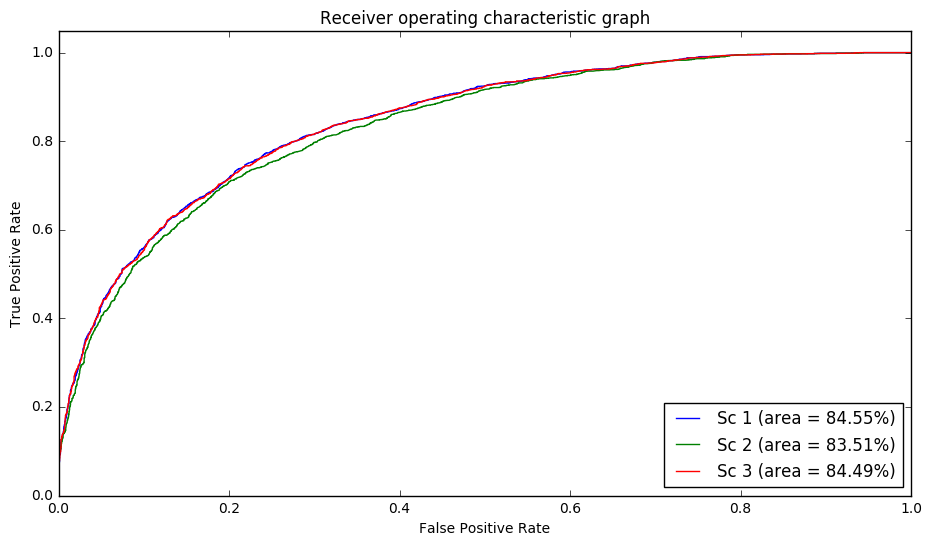

In [4]:
# Draw the ROC curves
plt.figure(figsize=(11,6))
for r in CRDF.itertuples():
    plt.plot(r.fpr, r.tpr, label='{} (area = {:0.2f}%)'.format(r.Label, r.auc*100))

#plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic graph')
plt.legend(loc="lower right")
plt.show()